In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn import svm
import xgboost as xgb

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ift3395-6390-arxiv/sample_submission.csv
/kaggle/input/ift3395-6390-arxiv/test.csv
/kaggle/input/ift3395-6390-arxiv/train.csv


In [26]:
train_data=pd.read_csv('/kaggle/input/ift3395-6390-arxiv/train.csv')
test_data = pd.read_csv('/kaggle/input/ift3395-6390-arxiv/test.csv') 


print(train_data[:2])

   Id                                           Abstract  Category
0   0    The energy released in a solar flare is part...  astro-ph
1   1    In light of current atmospheric neutrino osc...    hep-ph


In [27]:
train_vec = TfidfVectorizer(ngram_range=(1,3),min_df=2, max_df=0.9,smooth_idf=1, sublinear_tf=1,stop_words= "english", lowercase=True, norm='l2')
tfidf_train_data = train_vec.fit_transform(train_data['Abstract'])

y_train = train_data["Category"]

X_train, X_valid, y_train, y_valid = train_test_split(tfidf_train_data, y_train, test_size=0.2, random_state=None)

In [28]:
# for training and lôking for better hyper-parametres
from sklearn import metrics
def training(model, X_train, y_train, X_valid, y_valid):
    result = model.fit(X_train, y_train)
    prediction = model.predict(X_valid)
    print(metrics.classification_report(y_valid, prediction))
    return result

In [29]:
f1 = metrics.make_scorer(metrics.f1_score, average = 'macro')

In [30]:
from sklearn.model_selection import GridSearchCV

def selection_svm(model, parameters, cross, repeat):
    
    result = []
    
    selection = GridSearchCV(model, parameters, cv=cross, scoring = f1, n_jobs = repeat)
    selection.fit(X_train, y_train)
    
    print("Meilleur hyper-parameter: ", selection.best_params_)
    print("Meilleur f1: ", selection.best_score_, "\n")    

    print("Valeurs de C testés: ", selection.cv_results_['params'], "\n")
    print("Scores: ", selection.cv_results_['mean_test_score'], "\n")
    result.append(selection.cv_results_['params'])
    result.append(selection.cv_results_['mean_test_score'])
    
    return result
    


In [31]:
# model svc avec hinge

param_grid = {'C':[0.5,1,2,2.5,3,3.5,4,5]}

svc = svm.LinearSVC(loss='hinge')
svc_select = selection_svm(svc, param_grid, 8, 8)

 

Meilleur hyper-parameter:  {'C': 1}
Meilleur f1:  0.7980744235574153 

Valeurs de C testés:  [{'C': 0.5}, {'C': 1}, {'C': 2}, {'C': 2.5}, {'C': 3}, {'C': 3.5}, {'C': 4}, {'C': 5}] 

Scores:  [0.78673611 0.79807442 0.79508272 0.79284965 0.7922763  0.79210316
 0.79210317 0.79226041] 



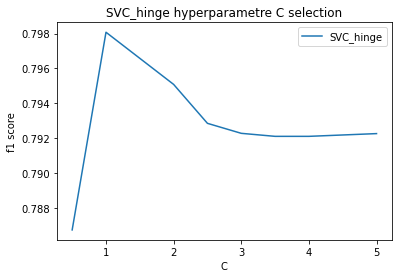

In [32]:
import matplotlib.pyplot as plt
ax_svc = plt.gca()
cv = pd.concat([pd.DataFrame(svc_select[0]), pd.DataFrame(svc_select[1])], axis=1)
cv.plot(kind='line',x='C', y=0,ax=ax_svc)
plt.legend(['SVC_hinge'])
plt.ylabel('f1 score')
plt.title('SVC_hinge hyperparametre C selection')
plt.show()

In [39]:
training(svc.set_params(C=1),X_train, y_train, X_valid, y_valid)

                   precision    recall  f1-score   support

         astro-ph       0.58      0.38      0.46        99
      astro-ph.CO       0.70      0.54      0.61       108
      astro-ph.GA       0.59      0.78      0.67        85
      astro-ph.SR       0.74      0.84      0.79        96
cond-mat.mes-hall       0.83      0.78      0.80        94
cond-mat.mtrl-sci       0.87      0.88      0.88       101
            cs.LG       0.77      0.83      0.79       103
            gr-qc       0.82      0.89      0.85       106
           hep-ph       0.92      0.89      0.90       105
           hep-th       0.89      0.85      0.87        97
          math.AP       0.95      0.97      0.96       108
          math.CO       0.93      0.97      0.95       100
   physics.optics       0.79      0.93      0.86        92
         quant-ph       0.92      0.86      0.89       109
          stat.ML       0.80      0.78      0.79        97

         accuracy                           0.81      

LinearSVC(C=1, loss='hinge')

In [34]:
# model svc avec squared_hinge
param_grid = {'C':[0.5,1,2,2.5,3,3.5,4,5]}

svc_squared_hinge = svm.LinearSVC(loss='squared_hinge')
svc_select_squared_hinge = selection_svm(svc_squared_hinge, param_grid, 8, 8)


Meilleur hyper-parameter:  {'C': 1}
Meilleur f1:  0.7991702839454328 

Valeurs de C testés:  [{'C': 0.5}, {'C': 1}, {'C': 2}, {'C': 2.5}, {'C': 3}, {'C': 3.5}, {'C': 4}, {'C': 5}] 

Scores:  [0.79837724 0.79917028 0.79768737 0.79680372 0.7961844  0.79504541
 0.7950679  0.79479317] 



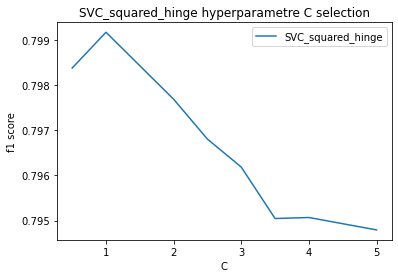

In [35]:
ax_svc_squared = plt.gca()
cv = pd.concat([pd.DataFrame(svc_select_squared_hinge[0]), pd.DataFrame(svc_select_squared_hinge[1])], axis=1)
cv.plot(kind='line',x='C', y=0,ax=ax_svc_squared)
plt.legend(['SVC_squared_hinge'])
plt.ylabel('f1 score')
plt.title('SVC_squared_hinge hyperparametre C selection')
plt.show()

In [36]:
training(svc_squared_hinge.set_params(C=1),X_train, y_train, X_valid, y_valid)

                   precision    recall  f1-score   support

         astro-ph       0.51      0.38      0.44        99
      astro-ph.CO       0.71      0.56      0.63       108
      astro-ph.GA       0.59      0.75      0.66        85
      astro-ph.SR       0.73      0.82      0.77        96
cond-mat.mes-hall       0.81      0.81      0.81        94
cond-mat.mtrl-sci       0.88      0.85      0.86       101
            cs.LG       0.79      0.82      0.80       103
            gr-qc       0.86      0.87      0.86       106
           hep-ph       0.92      0.89      0.90       105
           hep-th       0.86      0.86      0.86        97
          math.AP       0.95      0.97      0.96       108
          math.CO       0.95      0.96      0.96       100
   physics.optics       0.81      0.92      0.86        92
         quant-ph       0.93      0.89      0.91       109
          stat.ML       0.79      0.81      0.80        97

         accuracy                           0.81      

LinearSVC(C=1)

In [38]:
#for output

# test_data["Category"] = prediction
# test_data[["Id", "Category"]].to_csv("output.csv", index=False)